In [5]:
import random
import numpy as np
import pandas as pd
import copy
import time
from sklearn.preprocessing import OneHotEncoder

In [6]:
class Network(object):

    def __init__(self, sizes):
        
        '''The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers.'''

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        # helper variables
        self.bias_nitem = sum(sizes[1:])
        self.weight_nitem = sum([self.weights[i].size for i in range(self.num_layers-2)])

    def feedforward(self, a):
        '''Return the output of the network if ``a`` is input.'''
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w,a)+b)
        return a

    def sigmoid(self, z):
        '''The sigmoid function.'''
        return 1.0/(1.0+np.exp(-z))

    def score(self, X, y):

        '''
        @X = data to test
        @y = data-label to test
        @returns = score of network prediction (less is better)
        @ref: https://stats.stackexchange.com/questions/154879/a-list-of-cost-functions-used-in-neural-networks-alongside-applications
        '''

        total_score=0
        for i in range(X.shape[0]):
            predicted = self.feedforward(X[i].reshape(-1,1))
            actual = y[i].reshape(-1,1)
            total_score += np.sum(np.power(predicted-actual,2)/2)  # mean-squared error
        return total_score

    def accuracy(self, X, y):

        '''
        @X = data to test
        @y = data-label to test
        @returns = accuracy (%) (more is better)
        '''

        accuracy = 0
        for i in range(X.shape[0]):
            output = self.feedforward(X[i].reshape(-1,1))
            accuracy += int(np.argmax(output) == np.argmax(y[i]))
        return accuracy / X.shape[0] * 100

    def __str__(self):
        s = "\nBias:\n\n" + str(self.biases)
        s += "\nWeights:\n\n" + str(self.weights)
        s += "\n\n"
        return s

class NNGeneticAlgo:

    def __init__(self, n_pops, net_size, mutation_rate, crossover_rate, retain_rate, X, y):

        '''
        n_pops   = How much population do our GA need to create
        net_size = Size of neural network for population members
        mutation_rate = probability of mutating all bias & weight inside our network
        crossover_rate = probability of cross-overing all bias & weight inside out network
        retain_rate = How many to retain our population for the best ones
        X = our data to test accuracy
        y = our data-label to test accuracy
        '''

        self.n_pops = n_pops
        self.net_size = net_size
        self.nets = [Network(self.net_size) for i in range(self.n_pops)]
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.retain_rate = retain_rate
        self.X = X[:]
        self.y = y[:]
    
    def get_random_point(self, type):

        '''
        @type = either 'weight' or 'bias'
        @returns tuple (layer_index, point_index)
            note: if type is set to 'weight', point_index will return (row_index, col_index)
        '''

        nn = self.nets[0]
        layer_index, point_index = random.randint(0, nn.num_layers-2), 0
        if type == 'weight':
            row = random.randint(0,nn.weights[layer_index].shape[0]-1)
            col = random.randint(0,nn.weights[layer_index].shape[1]-1)
            point_index = (row, col)
        elif type == 'bias':
            point_index = random.randint(0,nn.biases[layer_index].size-1)
        return (layer_index, point_index)

    def get_all_scores(self):
        return [net.score(self.X, self.y) for net in self.nets]

    def get_all_accuracy(self):
        return [net.accuracy(self.X, self.y) for net in self.nets]

    def crossover(self, father, mother):

        '''
        @father = neural-net object representing father
        @mother = neural-net object representing mother
        @returns = new child based on father/mother genetic information
        '''

        # make a copy of father 'genetic' weights & biases information
        nn = copy.deepcopy(father)

        # cross-over bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # replace genetic (bias) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.biases[layer][point] = mother.biases[layer][point]

        # cross-over weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # replace genetic (weight) with mother's value
            if random.uniform(0,1) < self.crossover_rate:
                nn.weights[layer][point] = mother.weights[layer][point]
        
        return nn
        
    def mutation(self, child):

        '''
        @child_index = neural-net object to mutate its internal weights & biases value
        @returns = new mutated neural-net
        '''

        nn = copy.deepcopy(child)

        # mutate bias
        for _ in range(self.nets[0].bias_nitem):
            # get some random points
            layer, point = self.get_random_point('bias')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.biases[layer][point] += random.uniform(-0.5, 0.5)

        # mutate weight
        for _ in range(self.nets[0].weight_nitem):
            # get some random points
            layer, point = self.get_random_point('weight')
            # add some random value between -0.5 and 0.5
            if random.uniform(0,1) < self.mutation_rate:
                nn.weights[layer][point[0], point[1]] += random.uniform(-0.5, 0.5)

        return nn

    def evolve(self):

        # calculate score for each population of neural-net
        score_list = list(zip(self.nets, self.get_all_scores()))

        # sort the network using its score
        score_list.sort(key=lambda x: x[1])

        # exclude score as it is not needed anymore
        score_list = [obj[0] for obj in score_list]

        # keep only the best one
        retain_num = int(self.n_pops*self.retain_rate)
        score_list_top = score_list[:retain_num]

        # return some non-best ones
        retain_non_best = int((self.n_pops-retain_num) * self.retain_rate)
        for _ in range(random.randint(0, retain_non_best)):
            score_list_top.append(random.choice(score_list[retain_num:]))

        # breed new childs if current population number less than what we want
        while len(score_list_top) < self.n_pops:

            father = random.choice(score_list_top)
            mother = random.choice(score_list_top)

            if father != mother:
                new_child = self.crossover(father, mother)
                new_child = self.mutation(new_child)
                score_list_top.append(new_child)
        
        # copy our new population to current object
        self.nets = score_list_top

In [13]:
accuracy = []
def main():

    # load data from iris.csv into X and y
    df = pd.read_csv("penguins.csv")
    X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].values.astype(int)
    y = df['species'].values

    print(X)
    print(y)
    # convert y into one-hot encoded format
    y = y.reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(y)
    y = enc.transform(y).toarray()
    print(y)
    # parameters
    N_POPS = 30
    NET_SIZE = [4,20,3] 
    MUTATION_RATE = 0.2
    CROSSOVER_RATE = 0.4
    RETAIN_RATE = 0.4

    # start our neural-net & optimize it using genetic algorithm
    nnga = NNGeneticAlgo(N_POPS, NET_SIZE, MUTATION_RATE, CROSSOVER_RATE, RETAIN_RATE, X, y)

    start_time = time.time()
    
    # run for n iterations
    for i in range(1000):
        accuracy.append(nnga.get_all_accuracy()[0])
        if i % 10 == 0:
            print("Current iteration : {}".format(i+1))
            print("Time taken by far : %.1f seconds" % (time.time() - start_time))
            print("Current top member's network accuracy: %.2f%%\n" % nnga.get_all_accuracy()[0])

        # evolve the population
        nnga.evolve()

In [14]:
if __name__ == "__main__":
    main()

[[  39   18  181 3750]
 [  39   17  186 3800]
 [  40   18  195 3250]
 ...
 [  49   18  193 3775]
 [  50   19  210 4100]
 [  50   18  198 3775]]
['Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Adelie

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Current iteration : 1
Time taken by far : 0.2 seconds
Current top member's network accuracy: 43.84%

Current iteration : 11
Time taken by far : 6.1 seconds
Current top member's network accuracy: 35.74%

Current iteration : 21
Time taken by far : 12.1 seconds
Current top member's network accuracy: 43.84%

Current iteration : 31
Time taken by far : 18.1 seconds
Current top member's network accuracy: 43.84%

Current iteration : 41
Time taken by far : 24.8 seconds
Current top member's network accuracy: 48.35%

Current iteration : 51
Time taken by far : 30.5 seconds
Current top member's network accuracy: 48.35%

Current iteration : 61
Time taken by far : 40.9 seconds
Current top member's network accuracy: 48.35%

Current iteration : 71
Time taken by far : 46.8 seconds
Current top member's network accuracy: 48.35%

Current iteration : 81
Time taken by far : 52.7 seconds
Current top member's network accuracy: 48.35%

Current iteration : 91
Time taken by far : 58.7 seconds
Current top member's

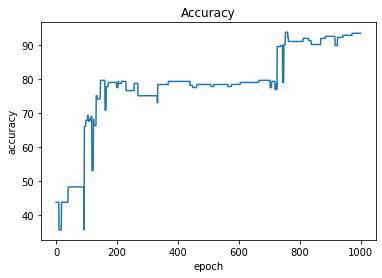

In [16]:
# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(accuracy)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()